# Chapter 6 – Decision Trees

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/06_decision_trees.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Like SVMs, Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets. For example, in Chapter 2 you trained a `DecisionTreeRegressor` model on the California housing dataset, fitting it perfectly (actually, overfitting it).

Decision Trees are also the fundamental components of Random Forests (see Chapter 7), which are among the most powerful Machine Learning algorithms available today.

In this chapter we will start by discussing how to train, visualize, and make predictions with Decision Trees. Then we will go through the CART training algorithm used by Scikit-Learn, and we will discuss how to regularize trees and use them for regression tasks. Finally, we will discuss some of the limitations of Decision Trees.

## Training and Visualizing a Decision Tree

To understand Decision Trees, let’s build one and take a look at how it makes predictions. The following code trains a `DecisionTreeClassifier` on the iris dataset (see Chapter 4):

In [2]:
from scipy.stats import reciprocal
reciprocal(0.001, 0.1)

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

You can visualize the trained Decision Tree by first using the `export_graphviz()` method to output a graph definition file called *iris_tree.dot*:

In [4]:
iris.target_names,

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),)

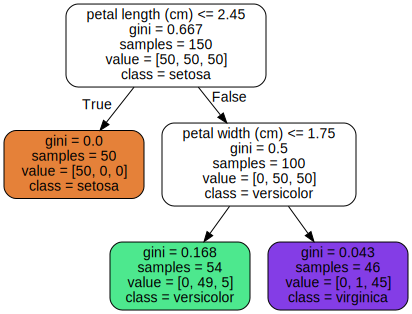

In [5]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

Figure 6-1. Iris Decision Tree

## Making Predictions

In [6]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

A node’s samples attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s value attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 Iris setosa, 1 Iris versicolor, and 45 Iris virginica. Finally, a node’s `gini` attribute measures its impurity: a node is “pure” `(gini=0)` if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris setosa training instances, it is pure and its `gini` score is 0. Equation 6-1 shows how the training algorithm computes the `gini` score $G_i$ of the $i^{th}$ node. The depth-2 left node has a `gini` score equal to $1 – (0/54)^2 – (49/54)^2 – (5/54)^2 \approx 0.168$. 

*Equation 6-1. Gini impurity*
$$G_i=1-\sum_{k=1}^{n}p_{i,k}^2$$
- $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.

Saving figure decision_tree_decision_boundaries_plot


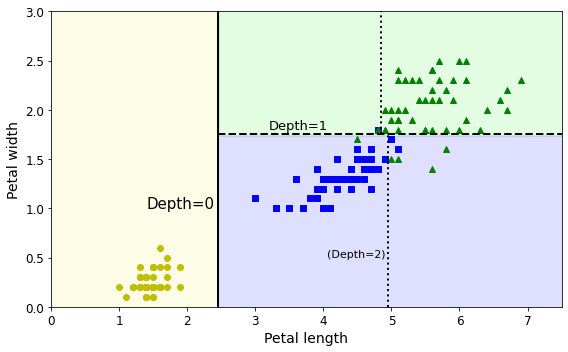

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 5))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

Figure 6-2. Decision Tree decision boundaries

## The CART Training Algorithm

Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train Decision Trees (also called “growing” trees). The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). How does it choose $k$ and $t_k$? It searches for the pair $(k, t_k)$ that produces the purest subsets (weighted by their size). Equation 6-2 gives the cost function that the algorithm tries to minimize.

*Equation 6-2. CART cost function for classification*
$$J(k,t_k)=\frac{m_{\text{left}}}{m}G_{\text{left}}+\frac{m_{\text{right}}}{m}G_{\text{right}}$$
where $$\begin{cases}
G_{\text{left/right}} & \text{ measures the impurity of the left/right subset,}\\
m_{\text{left/right}} & \text{ is the number of instances in the left/right subset,}\\
\end{cases}$$

## Gini Impurity or Entropy?  

By default, the Gini impurity measure is used, but you can select the *entropy* impurity measure instead by setting the `criterion` hyperparameter to `"entropy"`. The concept of entropy originated in thermodynamics as a measure of molecular disorder: entropy approaches zero when molecules are still and well ordered. Entropy later spread to a wide variety of domains, including Shannon’s information theory, where it measures the average information content of a message: entropy is zero when all messages are identical. In Machine Learning, entropy is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class. Equation 6-3 shows the definition of the entropy of the $i^{th}$ node. For example, the depth-2 left node in Figure 6-1 has an entropy equal to $–(49/54) log_2 (49/54) – (5/54) log_2 (5/54) \approx 0.445$.

*Equation 6-3. Entropy*  

$$H_i=−\underset{p_{i,k}\ne 0}{\sum_{k=1}^{n}}p_{i,k}\log_2(p_{i,k})$$
So, should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.

## Regularization Hyperparameters  

Decision Trees make very few assumptions about the training data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed, most likely overfitting it. Such a model is often called a nonparametric model, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a parametric model, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training. As you know by now, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the `max_depth` hyperparameter (the default value is None, which means unlimited). Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting.

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the Decision Tree: `min_samples_split` (the minimum number of samples a node must have before it can be split), `min_samples_leaf` (the minimum number of samples a leaf node must have), `min_weight_fraction_leaf` (same as min_samples_leaf but expressed as a fraction of the total number of weighted instances), `max_leaf_nodes` (the maximum number of leaf nodes), and `max_features` (the maximum number of features that are evaluated for splitting at each node). Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

Figure 6-3 shows two Decision Trees trained on the moons dataset (introduced in Chapter 5). On the left the Decision Tree is trained with the default hyperparameters (i.e., no restrictions), and on the right it’s trained with `min_samples_leaf=4`. It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

Saving figure min_samples_leaf_plot


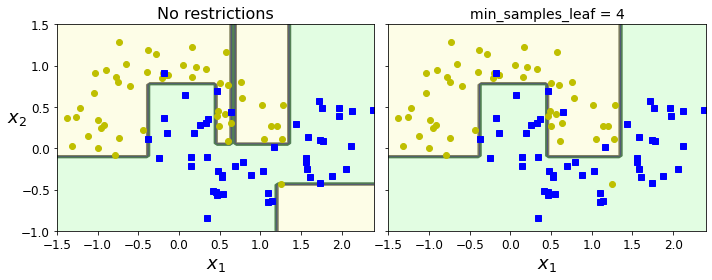

In [9]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

Figure 6-3. Regularization using min_samples_leaf

## Regression trees

Decision Trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with `max_depth=2`:

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

This model’s predictions are represented on the left in Figure 6-5. If you set `max_depth=3`, you get the predictions represented on the right. Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

In [11]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [12]:
X[:6], y[:6]

(array([[0.37454012],
        [0.95071431],
        [0.73199394],
        [0.59865848],
        [0.15601864],
        [0.15599452]]),
 array([[-0.00504175],
        [ 0.83579891],
        [ 0.244592  ],
        [-0.03250116],
        [ 0.65987015],
        [ 0.52074237]]))

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [14]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

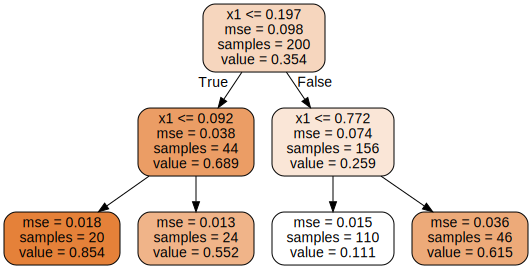

In [15]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

Figure 6-4. A Decision Tree for regression

This tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with $x_1 = 0.6$. You traverse the tree starting at the root, and you eventually reach the leaf node that predicts `value=0.111`. This prediction is the average target value of the 110 training instances associated with this leaf node, and it results in a mean squared error equal to 0.015 over these 110 instances.

Saving figure tree_regression_plot


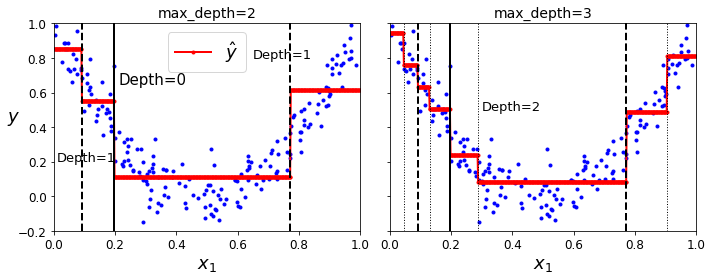

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

Figure 6-5. Predictions of two Decision Tree regression models

*Equation 6-4. CART cost function for regression*
$$J(k,t_k)=\frac{m_{\text{left}}}{m}\text{MSE}_{\text{left}}+\frac{m_{\text{right}}}{m}\text{MSE}_{\text{right}}$$
where $$\begin{cases}
\text{MSE}_{\text{node}} = \sum_{i\in \text{node}}^{}\left(\hat y_{\text{node}}-y^{(i)}\right)^2\\
\hat y_{\text{node}} = \frac{1}{m_{\text{node}}}\sum_{i\in \text{node}}y^{(i)}\\
\end{cases}$$

Saving figure tree_regression_regularization_plot


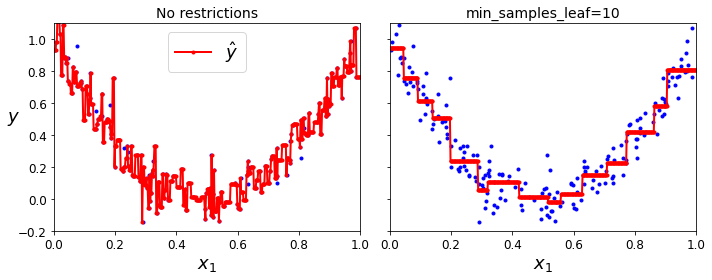

In [17]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

Figure 6-6. Regularizing a Decision Tree regressor

## Sensitivity to training set details  

Hopefully by now you are convinced that Decision Trees have a lot going for them: they are simple to understand and interpret, easy to use, versatile, and powerful. However, they do have a few limitations. First, as you may have noticed, Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. For example, Figure 6-7 shows a simple linearly separable dataset: on the left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted. Although both Decision Trees fit the training set perfectly, it is very likely that the model on the right will not generalize well. One way to limit this problem is to use Principal Component Analysis (see Chapter 8), which often results in a better orientation of the training data.

In [18]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

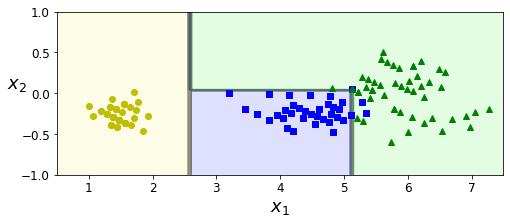

In [19]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

Saving figure sensitivity_to_rotation_plot


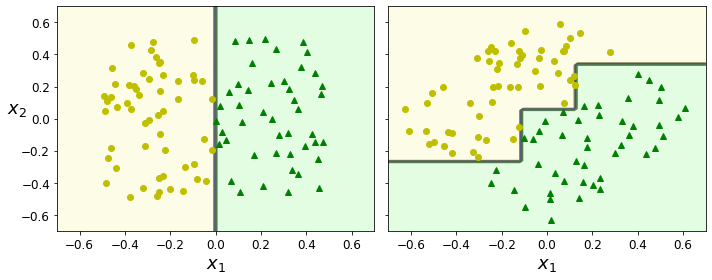

In [20]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

Figure 6-7. Sensitivity to training set rotation

In [21]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower

array([[4.8, 1.8]])

In [22]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

Saving figure decision_tree_instability_plot


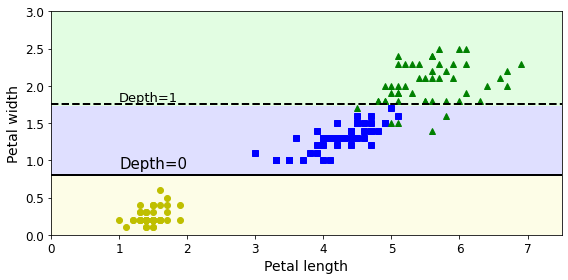

In [23]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

Figure 6-8. Sensitivity to training set details

## Exercise solutions

1. What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances?

> The depth of a well-balanced binary tree containing $m$ leaves is equal to $\log_2(m)$, rounded up. A binary Decision Tree (one that makes only binary decisions, as is the case with all trees in Scikit-Learn) will end up more or less well balanced at the end of training, with one leaf per training instance if it is trained without restrictions. Thus, if the training set contains one million instances, the Decision Tree will have a depth of $log_2(10^6) \approx 20$ (actually a bit more since the tree will generally not be perfectly well balanced).

2. Is a node’s Gini impurity generally lower or greater than its parent’s? Is it generally lower/greater, or always lower/greater?

>A node’s Gini impurity is generally lower than its parent’s. This is due to the CART training algorithm’s cost function, which splits each node in a way that minimizes the weighted sum of its children’s Gini impurities. However, it is possible for a node to have a higher Gini impurity than its parent, as long as this increase is more than compensated for by a decrease in the other child’s impurity. For example, consider a node containing four instances of class A and one of class B. Its Gini impurity is $1 – (1/5)^2 – (4/5)^2 = 0.32$. Now suppose the dataset is one-dimensional and the instances are lined up in the following order: A, B, A, A, A. You can verify that the algorithm will split this node after the second instance, producing one child node with instances A, B, and the other child node with instances A, A, A. The first child node’s Gini impurity is $1 – (1/2)^2 – (1/2)^2 = 0.5$, which is higher than its parent’s. This is compensated for by the fact that the other node is pure, so its overall weighted Gini impurity is $2/5 × 0.5 + 3/5 × 0 = 0.2$, which is lower than the parent’s Gini impurity.

3. If a Decision Tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?

>If a Decision Tree is overfitting the training set, it may be a good idea to decrease `max_depth`, since this will constrain the model, regularizing it.

4. If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?  

>Decision Trees don’t care whether or not the training data is scaled or centered; that’s one of the nice things about them. So if a Decision Tree underfits the training set, scaling the input features will just be a waste of time.

5. If it takes one hour to train a Decision Tree on a training set containing 1 million instances, roughly how much time will it take to train another Decision Tree on a training set containing 10 million instances? 

>The computational complexity of training a Decision Tree is $O(n × m \log(m))$. So if you multiply the training set size by 10, the training time will be multiplied by $K = (n × 10m × \log(10m)) / (n × m × \log(m)) = 10 × \log(10m) / \log(m)$. If $m = 10^6$, then $K \approx 11.4$, so you can expect the training time to be roughly 11.4 hours.


In [24]:
m = 10e6
10 * np.log(10*m) / np.log(m)

11.42857142857143

6. If your training set contains 100,000 instances, will setting `presort=True` speed up training? 

>Presorting the training set speeds up training only if the dataset is smaller than a few thousand instances. If it contains 100,000 instances, setting `presort=True` will considerably slow down training.

7.  Train and fine-tune a Decision Tree for the moons dataset._

a. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

Adding `random_state=42` to make this notebook's output constant:

In [25]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. Split it into a training set and a test set using `train_test_split()`.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [27]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
#min_samples_splitint or float, default=2 The minimum number of samples required to split an internal node
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    5.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [28]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

By default, `GridSearchCV` trains the best model found on the whole training set (you can change this by setting `refit=False`), so we don't need to do it again. We can simply evaluate the model's accuracy:

In [29]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

8. Grow a forest by following these steps:

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [31]:
len(X_train)

8000

In [30]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [40]:
len(mini_sets), mini_sets[0][0].shape, mini_sets[0][1].shape

(1000, (100, 2), (100,))

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [41]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

In [53]:
len(accuracy_scores), accuracy_scores[0]

(1000, 0.7985)

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [42]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [57]:
Y_pred.shape

(1000, 2000)

In [43]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [56]:
y_pred_majority_votes,y_pred_majority_votes.shape, n_votes,n_votes.shape, y_test, y_test.shape

(array([[1, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 (1, 2000),
 array([[951, 912, 963, ..., 919, 994, 602]]),
 (1, 2000),
 array([1, 1, 0, ..., 0, 0, 0]),
 (2000,))

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [44]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872